In [197]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [198]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [199]:
len(words)

32033

In [200]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [201]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])       # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte, Yte = build_dataset(words[n2:])       # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [202]:
# MLP revisisted
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the umber of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [203]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # BatchNorm layer
    # --------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # --------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3239


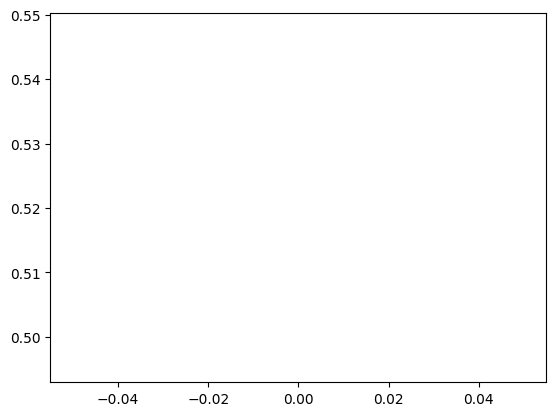

In [204]:
plt.plot(lossi)

In [205]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [206]:
bnstd

tensor([[1.6840, 1.1235, 1.6279, 1.4772, 1.8441, 1.3804, 1.0839, 1.2039, 1.8157,
         1.2710, 1.5329, 1.3324, 1.2541, 1.5638, 1.0330, 1.2641, 2.2182, 1.2429,
         1.5762, 1.3876, 1.4302, 1.6492, 1.4990, 1.9692, 1.3687, 1.4062, 1.3033,
         1.5226, 2.1862, 1.7276, 1.1595, 1.1241, 1.9767, 1.4049, 1.7413, 1.4249,
         1.1745, 1.9101, 1.3168, 1.6866, 1.3388, 1.7175, 1.6233, 2.3459, 1.3176,
         1.3874, 1.5161, 1.4830, 0.9393, 1.4007, 1.3294, 1.2036, 1.2193, 1.4799,
         1.4338, 1.5064, 1.2415, 1.8060, 2.1547, 1.3617, 1.2375, 1.3414, 1.1999,
         1.4553, 1.7379, 1.5579, 1.5001, 1.3118, 1.5562, 1.8673, 1.4541, 1.6955,
         1.3430, 0.9877, 1.2080, 1.3714, 1.5662, 1.7963, 1.5484, 1.3829, 1.8231,
         1.5669, 1.6670, 2.0943, 1.6274, 1.7860, 1.4103, 1.4744, 1.2587, 1.1606,
         1.3901, 1.6089, 1.6135, 2.5059, 2.1190, 1.3390, 1.8234, 1.5040, 1.1357,
         1.4718, 1.4059, 1.6239, 1.8771, 1.1733, 1.4919, 1.2568, 1.5574, 1.3757,
         1.5831, 1.8178, 1.2

In [207]:
bnstd_running

tensor([[1.0006, 1.0000, 1.0007, 1.0002, 1.0006, 1.0004, 1.0006, 1.0002, 1.0006,
         1.0002, 1.0002, 1.0004, 1.0004, 1.0008, 0.9996, 1.0005, 1.0011, 1.0003,
         1.0004, 1.0004, 1.0006, 1.0008, 1.0003, 1.0007, 1.0003, 1.0003, 1.0003,
         1.0005, 1.0015, 1.0004, 1.0000, 1.0002, 1.0008, 1.0004, 1.0007, 1.0004,
         1.0001, 1.0007, 1.0003, 1.0004, 1.0001, 1.0006, 1.0002, 1.0011, 1.0003,
         1.0007, 1.0008, 1.0005, 0.9998, 1.0003, 1.0002, 1.0004, 1.0001, 1.0003,
         1.0004, 1.0005, 1.0005, 1.0009, 1.0009, 1.0004, 1.0003, 1.0005, 1.0004,
         1.0004, 1.0006, 1.0005, 1.0007, 1.0002, 1.0010, 1.0007, 1.0003, 1.0004,
         1.0002, 0.9998, 1.0001, 1.0001, 1.0006, 1.0008, 1.0003, 1.0006, 1.0007,
         1.0004, 1.0005, 1.0005, 1.0008, 1.0004, 1.0003, 1.0004, 1.0002, 1.0002,
         1.0004, 1.0006, 1.0010, 1.0010, 1.0005, 1.0005, 1.0007, 1.0004, 1.0002,
         1.0007, 1.0003, 1.0011, 1.0008, 1.0003, 1.0001, 1.0002, 1.0006, 1.0003,
         1.0003, 1.0012, 1.0

In [208]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_ebd)
    hpreact = embcat @ W1 + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias    
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 3.2700417041778564
val 3.2691590785980225


In [209]:
# loss log

# original:
train 2.1245384216308594
val   2.1681964397430420

# fix softmax confidently wrong:
train 2.07
val   2.13

# fix tanh layer too saturated at init:
train 2.0355966091156006
val   2.1026785373687744

# add a batch norm layer
train 2.0668270587921143
val   2.104844808578491

SyntaxError: invalid syntax (1410450987.py, line 4)

In [210]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass with neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out)) # decode and print the generated word

erbujgmyazzhzelvndhfyllwqetvrsjejdrljg.
azcjedoeliizsmpqppalekepxvqnwxarveptzcmhvqrpcn.
szdbvrgxhgmjest.
jcjrwjejqqxntpucfkubzkgvdcrxyqqufmehg.
kmejqvskkydmzhjl.
cakyybsufpzbjglvjurenjcrtvwsvevoecmpfhdxjfqyxoeobhggpcixjsfcueywh.
hmrjolvii.
qirf.
wvpkxwvlla.
odtabfsztpnegoikvsbmitgfkxvbssivpu.
meewrkepxcmvyhxavttudkjgczekhgcgtipvtudw.
iwbdnihzvorlq.
cjakepxugniagcfpppfmiipzjgvonxet.
jynnblkskzporygnogsvmwosfzybsyknvmjcxtxncjbmu.
jtew.
aow.
copmrlxkkdcqbcep.
ccdfivsnicimhtecmokagouwzlrurdckappomtcokwxtnbnzkdphfam.
xcojfffuqcxzhosy.
sj.


In [211]:
# SUMMARY ---------------------------

In [243]:
# Let's train a deeper network

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [ self.weight] + ([] if self.bias is None else [self.bias])
        
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)     # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [249]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) #concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 1.0 #0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.7167


layer 2 (      Tanh): mean -0.01, std 0.64, saturated: 3.59%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 3.62%
layer 8 (      Tanh): mean -0.03, std 0.65, saturated: 3.31%
layer 11 (      Tanh): mean -0.02, std 0.65, saturated: 3.38%
layer 14 (      Tanh): mean +0.04, std 0.65, saturated: 2.75%


Text(0.5, 1.0, 'activation distribution')

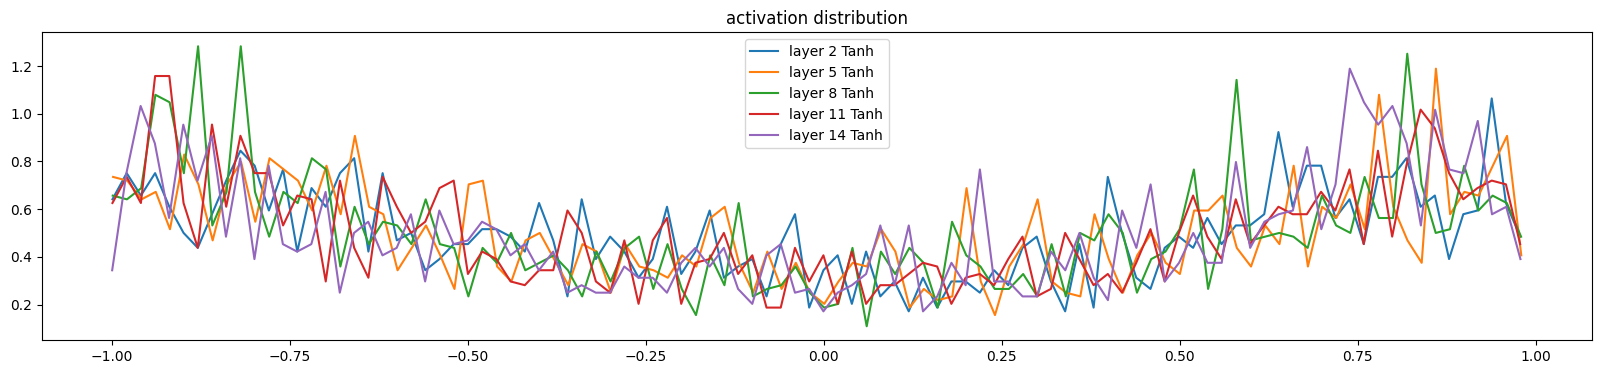

In [250]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'gradient distribution')

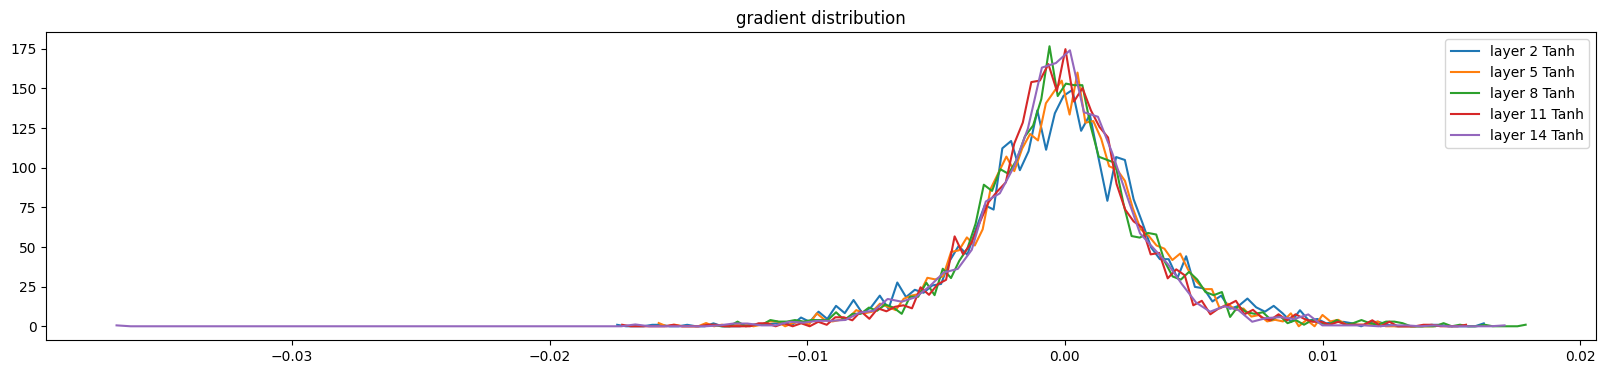

In [251]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 5.908947e-03 | grad:data ratio 5.697377e-03
weight  (30, 100) | mean -0.000011 | std 2.178575e-03 | grad:data ratio 2.118675e-03
weight (100, 100) | mean +0.000017 | std 1.195664e-03 | grad:data ratio 1.198492e-03
weight (100, 100) | mean -0.000005 | std 1.146400e-03 | grad:data ratio 1.137268e-03
weight (100, 100) | mean +0.000006 | std 1.066832e-03 | grad:data ratio 1.062862e-03
weight (100, 100) | mean +0.000011 | std 1.032334e-03 | grad:data ratio 1.027563e-03
weight  (100, 27) | mean -0.000002 | std 1.782237e-03 | grad:data ratio 1.798891e-03


Text(0.5, 1.0, 'gradient distribution')

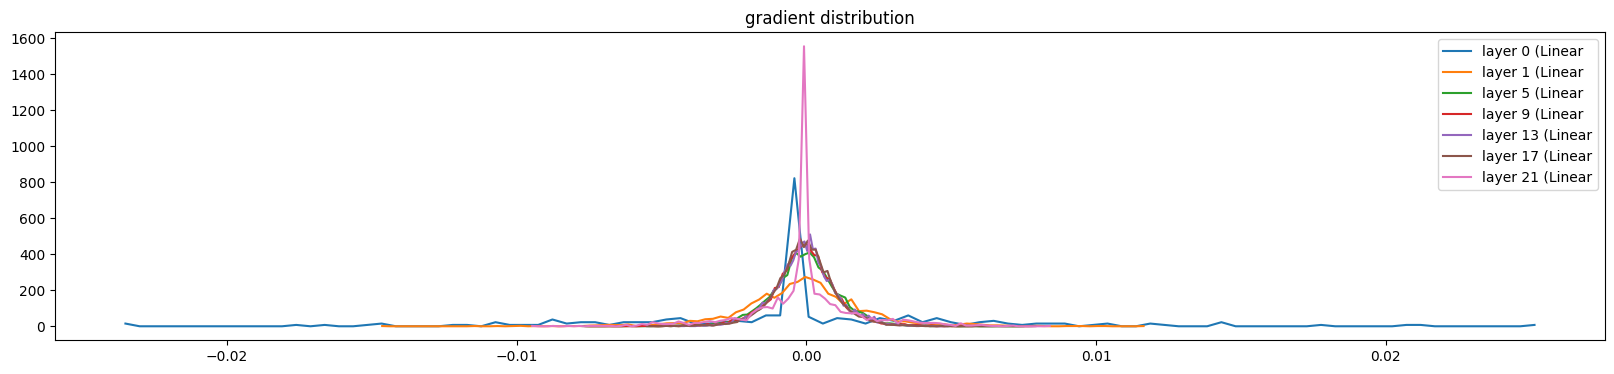

In [252]:
# visualize histograms
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

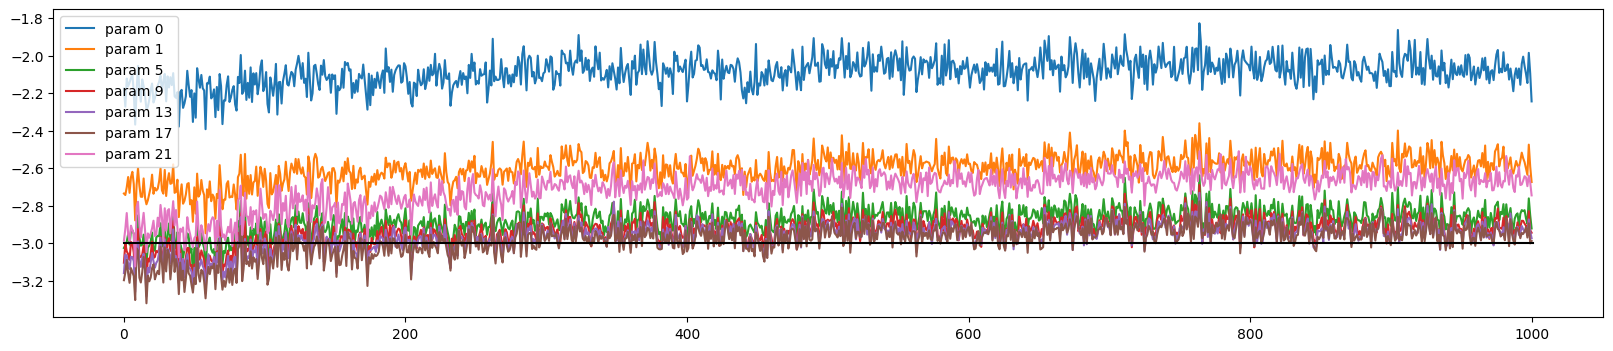

In [253]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);